# SETUP
---

## import packages

In [1]:
import pandas as pd
import numpy as np
import time

# file related packages
import glob
from fastparquet import ParquetFile

# model preparation
import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# supervised learning algorithms
from sklearn.naive_bayes import MultinomialNB           # Multinomial Naive Bayes (Multi-class Classification)
from sklearn.neighbors import KNeighborsClassifier      # K Nearest Neighbor Classification
from sklearn.neighbors import KNeighborsRegressor      # K Nearest Neighbor Regression
from sklearn.ensemble import RandomForestClassifier     # Random Forest Classification
from sklearn.ensemble import RandomForestRegressor      # Random Forest Regression
from sklearn.ensemble import GradientBoostingClassifier # Gradient Boosting Classification
from sklearn.ensemble import GradientBoostingRegressor # Gradient Boosting Regression
from sklearn.svm import SVC                             # Support Vector Classification
from sklearn.svm import SVR                             # Support Vector Regression
from xgboost import XGBClassifier                       # Extreme Gradient Boosting Classification


# model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

## set plot style

## define constants

In [2]:
VERBOSE = True
DEBUG = False
SAMPLE_RATE = 0.1
RANDOM_STATE = 1220
TRAIN_SIZE = 0.8

## load dataset

In [3]:
df = pd.read_csv('instacart_clustered.csv')
print(df.shape)
df.head()

(206059, 34)


user_id  d1  d2  d3  d4  d5  d6  d7  d8  d9  ...  order_number  order_dow  \
0        1   0   0   0   5   0   0  15   0   0  ...            11   2.636364   
1        2  17   0   2  36   0   3   9   0   0  ...            14   2.142857   
2        3   6   0   0  38   0   0   3   0   4  ...            13   1.384615   
3        4   3   0   2   2   2   0   3   0   0  ...             6   4.500000   
4        5   2   0   0  23   0   4   0   0   1  ...             5   1.400000   

   order_hour  days_elapsed  reord1_log1p  num_items_log1p  \
0   10.090909     17.272727      1.729239         1.996554   
1   10.571429     14.142857      2.033772         2.703277   
2   16.307692     11.076923      1.654558         2.050171   
3   12.500000     14.166667      0.154151         1.386294   
4   15.000000      9.200000      1.526056         2.322388   

   order_number_log1p  days_elapsed_log1p  Cluster1  Cluster2  
0            2.484907            2.905410         3         0  
1            2.708050            2.717529         3         0  
2            2.639057            2.491296         3         0  
3            1.945910            2.719100         1         2  
4            1.791759            2.322388         3         0  

[5 rows x 34 columns]

# HELPER FUNCTIONS
---

## feature importance

In [21]:
def get_feature_importance(rgr, X_, Y_,title='Feature Importance'):
    print('--- Feature Importance ---')
    
    # start timer
    t0 = time.time()
    
    # fit model
    rgr.fit(X_,Y_)

    try:
        # get feature importance
        fi = rgr.feature_importances_
    except:
        print('\t --- NOTE: Feature Importance Not Supported ---')
        return
    
    # Make importances relative to max importance.
    fi = 100.0 * (fi / fi.max())

    # get sort IDs to align with feature name
    sorted_idx = np.argsort(fi)
    
    # set figure size
    plt.rcParams['figure.figsize'] = (12,6)
    
    # plot bar plot
    sns.barplot(X_.columns[sorted_idx], fi[sorted_idx], palette='Set1_r')
    plt.ylabel('Relative Importance')
    plt.xlabel('Feature')

    plt.xticks(rotation=90)
    plt.title(title, fontsize=18)

    plt.tight_layout()
    plt.show()
    print(f'Feature Importance completed in {time.time()-t0:.2f} seconds.')

## regression cross-validation

In [5]:
def run_regressor(X_, Y_, regressor='rfr',**kwargs):
    
    if VERBOSE:
        print(f'--- run_regresor(): kwargs = {kwargs} ---')

    # start time
    start_time = time.time()
    
    # set plot size
    plt.rcParams['figure.figsize'] = (8,4)

    # choose classifier
    if VERBOSE:
        print('\t--- Selecting Regressor ---')
    if regressor == 'ols':
        rgr = LinearRegression()
    elif regressor == 'lasso':
        rgr = LassoCV(alphas=kwargs['alphas'], cv=kwargs['cv'])
    elif regressor == 'ridge':
        rgr = RidgeCV(alphas=kwargs['alphas'], cv=kwargs['cv'])
    elif regressor == 'elastic':
        rgr = ElasticNetCV(alphas=kwargs['alphas'], cv=kwargs['cv'], l1_ratio=kwargs['l1_ratio'])
    elif regressor == 'rfr':
        rgr = RandomForestRegressor(
            n_estimators=kwargs['n_estimators'], 
            criterion=kwargs['criterion'], 
            max_depth=kwargs['max_depth'], 
            bootstrap=kwargs['bootstrap']
        )
    elif regressor == 'gbr':
        rgr = GradientBoostingRegressor(
            learning_rate=kwargs['learning_rate'], 
            n_estimators=kwargs['n_estimators'],
            subsample=kwargs['subsample'],
            loss=kwargs['loss']
        )
    elif regressor == 'knn':
        rgr = KNeighborsRegressor(
            n_neighbors=kwargs['n_neighbors'],
            weights=kwargs['weights'],
            algorithm=kwargs['algorithm']
        )
    elif regressor == 'svr':
        rgr = SVR(
            C=kwargs['C'],
            kernel=kwargs['kernel']
        )
    else:
        raise 'Unknown classifier'

    # use stratified k-fold
    skf = StratifiedKFold(shuffle=True, n_splits=10)
    skf.get_n_splits(X_, Y_)        

    # run cross validation
    if VERBOSE:
        print('\t--- Executing cross-validation ---')
    cv = cross_val_score(rgr, X_, Y_, cv=10, scoring='neg_mean_squared_error')
    cv = cv * -1

    # convert results to single row dataframe
    cv = pd.DataFrame(cv).T

    # add mean
    cv['mean'] = cv.mean(axis=1)
    cv['std'] = cv.drop(['mean'],axis=1).std(axis=1)
    if VERBOSE:
        print('\t---',cv[['mean','std']],'---')

    # show cross validation heatmap
    plt.subplot(2,1,1)
    sns.heatmap(cv.drop(['std'],axis=1), cmap='RdYlGn_r', square=True, linewidth=0.5, annot=True, cbar=False)
    plt.yticks([])
    plt.xlabel('folds')
    plt.ylabel('score')
    plt.title('10-fold Cross Validation', fontsize=16)
              
    # train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X_, Y_, test_size=0.1)

    # execute fit on train dataset
    rgr.fit(X_train,y_train)
       
    if regressor in ['ols','lasso','ridge','elastic']:
        if regressor == 'ols':
            # add constant
            X_train = sm_.add_constant(X_train)

            # run statsmodels OLS
            results = sm_.OLS(y_train, X_train).fit()

            # print summary
            print(results.summary())
        else:
            print('\n--- Model Evaluation ---')
            print('Train R^2: ',rgr.score(X_train,y_train))
            print('Test R^2: ',rgr.score(X_test,y_test))
            
            print('\n--- Model Coefficients ---')
            print(rgr.coef_)
        
            print('\n--- Model Intercept (Constant) ---')
            print(rgr.intercept_)
            
            print('\n--- Best Alphas ---')
            print(rgr.alpha_)
            
            if regressor == 'elastic':
                print('\n--- l1 ratio ---')
                print(rgr.l1_ratio_)

    # get predictions on test dataset
    y_pred = rgr.predict(X_test)
    
    plt.tight_layout()
    plt.show()
    print(f'--- Completed in {(time.time() - start_time):.4f} seconds\n')
    return y_test, y_pred

## error analysis

In [44]:
def regression_error_analysis(model, dfx_std, dfy_std, xscaler, yscaler, rgr, plot=True):
    print('--- Regression Error Analysis ---')
    t0 = time.time()
        
    # train test split 
    x_train = dfx_std.sample(frac=TRAIN_SIZE, random_state=RANDOM_STATE).values
    x_test = dfx_std.drop(dfx_std.sample(frac=TRAIN_SIZE, random_state=RANDOM_STATE).index).values
    y_train = dfy_std.sample(frac=TRAIN_SIZE, random_state=RANDOM_STATE).values.reshape(-1, 1)
    y_test = dfy_std.drop(dfy_std.sample(frac=TRAIN_SIZE, random_state=RANDOM_STATE).index). values.reshape(-1,1)
    
    if DEBUG:
        print(x_train.shape,x_test.shape)
        print(y_train.shape,y_test.shape)
    
    # fit model
    rgr.fit(x_train, y_train)
    
    # get predictions
    y_pred = rgr.predict(x_test)
    
    # inverse scaler transform
    targets = yscaler.inverse_transform(y_test)
    predictions = yscaler.inverse_transform(y_pred)

    # inverse log transform
    targets = np.expm1(targets)
    predictions = np.expm1(predictions)
    
    # add predictions and residuals to original dataframe
    test_df = model.drop(model.sample(frac=TRAIN_SIZE, random_state=RANDOM_STATE).index)
    test_df['predictions'] = predictions
    test_df['residuals'] = test_df.days_elapsed - test_df.predictions
    test_df.Cluster1 = test_df.Cluster1.astype(int)
    
    if DEBUG:
        print(test_df)
    
    if plot:
        plt.rcParams['figure.figsize'] = (24,18)
        
        plt.subplot(3,3,1)
        sns.scatterplot(data=test_df, x='days_elapsed', y='predictions', hue='Cluster1', palette=['blue','orange','green','red'])
        plt.xlabel('Actual Days Elapsed')
        plt.ylabel('Predicted Days Elapsed')
        plt.title('Predicted vs. Actual',fontsize=20)
        
        plt.subplot(3,3,2)
        sns.scatterplot(data=test_df, x='days_elapsed', y='residuals', hue='Cluster1', palette=['blue','orange','green','red'])
        plt.xlabel('Days Elapsed')
        plt.ylabel('Residuals (Actual - Prediction)')
        plt.title('Residuals vs. Actual',fontsize=20)
        
        plt.subplot(3,3,3)
        sns.scatterplot(data=test_df, x='order_number', y='residuals', hue='Cluster1', palette=['blue','orange','green','red'])
        plt.xlabel('Number of Orders')
        plt.ylabel('Residuals (Actual - Prediction)')
        plt.title('Residuals vs. Number of Orders',fontsize=20)
        
        plt.subplot(3,3,4)
        sns.scatterplot(data=test_df, x='num_items', y='residuals', hue='Cluster1', palette=['blue','orange','green','red'])
        plt.xlabel('num_items')
        plt.ylabel('Residuals (Actual - Prediction)')
        plt.title('Residuals vs. Mean Number of Items Ordered',fontsize=20)
        
        plt.subplot(3,3,5)
        sns.scatterplot(data=test_df, x='reord1', y='residuals', hue='Cluster1', palette=['blue','orange','green','red'])
        plt.xlabel('reord1')
        plt.ylabel('Residuals (Actual - Prediction)')
        plt.title('Residuals vs. Mean Number of Items Re-Ordered',fontsize=20)
        
        plt.subplot(3,3,6)
        sns.scatterplot(data=test_df, x='d4', y='residuals', hue='Cluster1', palette=['blue','orange','green','red'])
        plt.xlabel('d4')
        plt.ylabel('Residuals (Actual - Prediction)')
        plt.title('Residuals vs. Number of Produce Items Ordered',fontsize=20)
        
        plt.subplot(3,3,7)
        sns.scatterplot(data=test_df, x='d16', y='residuals', hue='Cluster1', palette=['blue','orange','green','red'])
        plt.xlabel('d16')
        plt.ylabel('Residuals (Actual - Prediction)')
        plt.title('Residuals vs. Number of Dairy/Eggs Items Ordered',fontsize=20)
        
        plt.subplot(3,3,8)
        sns.scatterplot(data=test_df, x='d7', y='residuals', hue='Cluster1', palette=['blue','orange','green','red'])
        plt.xlabel('d7')
        plt.ylabel('Residuals (Actual - Prediction)')
        plt.title('Residuals vs. Number of Beverage Items Ordered',fontsize=20)
        
        plt.subplot(3,3,9)
        sns.scatterplot(data=test_df, x='d19', y='residuals', hue='Cluster1', palette=['blue','orange','green','red'])
        plt.xlabel('d19')
        plt.ylabel('Residuals (Actual - Prediction)')
        plt.title('Residuals vs. Number of Snack Items Ordered',fontsize=20)
        
        plt.tight_layout()
        plt.show()
    print(f'\t--- RMSE={np.sqrt(np.mean((predictions-targets)**2)):.2f} ---')
    print(f'\t--- MSE={np.mean((predictions-targets)**2):.2f} ---')
    print(f'\t--- MAE={np.mean((predictions-targets)):.2f} ---')
    print(f'--- Regression Error Analysis Completed in {time.time()-t0:.2f} seconds ---')

# SUPERVISED LEARNING
---

## define model

In [7]:
# save off department list for later use
dept_list = ['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'd11',
             'd12', 'd13', 'd14', 'd15', 'd16', 'd17', 'd18', 'd19', 'd20', 'd21']

In [8]:
def define_model(df_model, dept_PCA=True):
    print('--- Defining Model ---')
    t0 = time.time()
    
    x_scaler = StandardScaler()
    
    # do pca on departments
    if dept_PCA:
        depts = x_scaler.fit_transform(df_model.loc[:, 'd1':'d21'])
        pca = PCA(n_components=5)
        pca_data = pca.fit_transform(depts)

        print('\t--- PCA Results ---')
        print('\t--- % Variance explained by each component',pca.explained_variance_ratio_)
        print('\t--- % Varaince explained by all components:',f'{sum(pca.explained_variance_ratio_)*100:.2f}%')
    
    
    # select features
    if dept_PCA:
        df_model = df_model[['reord1','reord1_log1p','num_items','num_items_log1p','order_number','order_number_log1p','Cluster1','days_elapsed','days_elapsed_log1p']].copy()
    else:
        df_model = df_model[['reord1','reord1_log1p','num_items','num_items_log1p','order_number','order_number_log1p','Cluster1','days_elapsed','days_elapsed_log1p'] + dept_list].copy()
    df_model.Cluster1 = df_model.Cluster1.astype(str)
    print('\t--- Initial Features Selected ---')
    if DEBUG:
        print('\t---',df_model.columns.to_list())
    
    # one-hot encoding
    X = pd.get_dummies(df_model.drop(['reord1','num_items','order_number','order_number_log1p','days_elapsed','days_elapsed_log1p',], axis=1), drop_first=True)
    print('\t--- One-Hot Encoding Completed ---')
    if DEBUG:
        print('\t---',X.columns.to_list())
    
    # standardize input variables
    X_std = x_scaler.fit_transform(X)
    print('\t--- Input Variable Standardization Completed ---')
    if DEBUG:
        print('\t---',X_std.shape)
    
    # add pca components
    if dept_PCA:
        X_std_orig = X_std
        X_std = np.concatenate((X_std_orig,pca_data),axis=1)
        df_X_std = pd.DataFrame(X_std)
        df_X_std.columns = X.columns.to_list() + ['pca1','pca2','pca3','pca4','pca5']
        print('\t--- PCA Components Added to Model ---')
    else:
        df_X_std = pd.DataFrame(X_std)
        df_X_std.columns = X.columns.to_list()
    if DEBUG:
            print('\t---',df_X_std.columns.to_list())
    
    # select output variable
    Y = df_model.days_elapsed_log1p

    # standardize output variables
    y_scaler = StandardScaler()
    Y_std = y_scaler.fit_transform(Y.values.reshape(-1,1))
    df_Y_std = pd.DataFrame(Y_std)
    print('\t--- Target Variable Defined and Standardized ---')
    if DEBUG:
        print('\t---',df_Y_std.columns.to_list())
    
    return df_model, df_X_std, df_Y_std, x_scaler, y_scaler, X_std, Y_std, X, Y

In [13]:
# sample original dataframe
df_model = df.copy().sample(frac=SAMPLE_RATE , random_state=RANDOM_STATE)

# define model
df_model, df_X_std, df_Y_std, x_scaler, y_scaler, X_std, Y_std, X, Y = define_model(df_model, False)

if VERBOSE:
    print(df_model.shape)
    print(df_X_std.shape)
    print(df_Y_std.shape)
    print(X_std.shape)
    print(Y_std.shape)

if DEBUG:
    print(df_model.head())
    print(df_X_std.head())
    print(df_Y_std.head())

--- Defining Model ---
	--- Initial Features Selected ---
	--- One-Hot Encoding Completed ---
	--- Input Variable Standardization Completed ---
	--- Target Variable Defined and Standardized ---
(20606, 30)
(20606, 26)
(20606, 1)
(20606, 26)
(20606, 1)


## random forest regression

### default tuning

--- Random Forest Regression: Default Parameters ---
--- run_regresor(): kwargs = {'n_estimators': 100, 'criterion': 'mse', 'max_depth': None, 'bootstrap': True} ---
	--- Selecting Regressor ---
	--- Executing cross-validation ---
	---        mean       std
0  0.673449  0.026658 ---


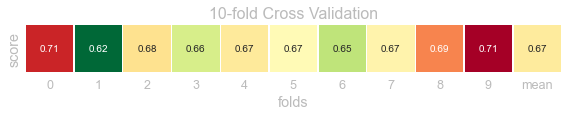

--- Completed in 327.3360 seconds



In [11]:
print('--- Random Forest Regression: Default Parameters ---')
actual, predicted = run_regressor(X_std, Y_std, 'rfr', n_estimators=100, criterion='mse', max_depth=None, bootstrap=True)

### grid search

In [ ]:
print('--- Random Forest Regression: Grid Search ---')

# start timer
t0 = time.time()

# define regressor
rgr = RandomForestRegressor()

# define parameters
param_grid = {
    'n_estimators':[50, 100, 200],
    'criterion':['mse','mae'],
    'max_depth':[None,4],
    'bootstrap':[True,False]
}

# run grid search
grid = GridSearchCV(rgr, param_grid, refit=True)

# fit to model
grid.fit(X_std,Y_std)

print('\t --- Best Parameters ---')
print('\t',grid.best_params_)

print(f'\t--- Random Forest Regression grid search completed in {time.time()-t0:.2f} seconds')

In [ ]:
print('--- Random Forest Regression: Tuned Parameters ---')
actual, predicted = run_regressor(X_std, Y_std, 'rfr', n_estimators=100, criterion='mse', max_depth=None, bootstrap=True)

In [15]:
rgr = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=None, bootstrap=True)

--- Feature Importance ---


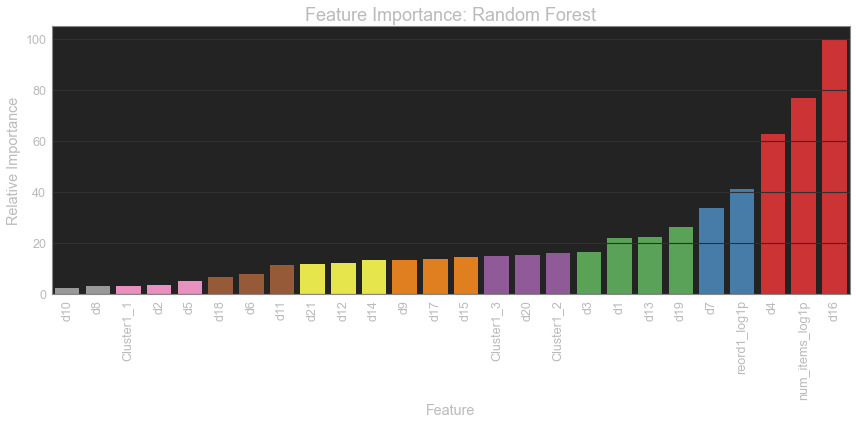

Feature Importance completed in 33.73 seconds.


In [22]:
# feature importance
rgr.fit(X_std,Y_std)
get_feature_importance(rgr, df_X_std, df_Y_std, 'Feature Importance: Random Forest')

--- Regression Error Analysis ---


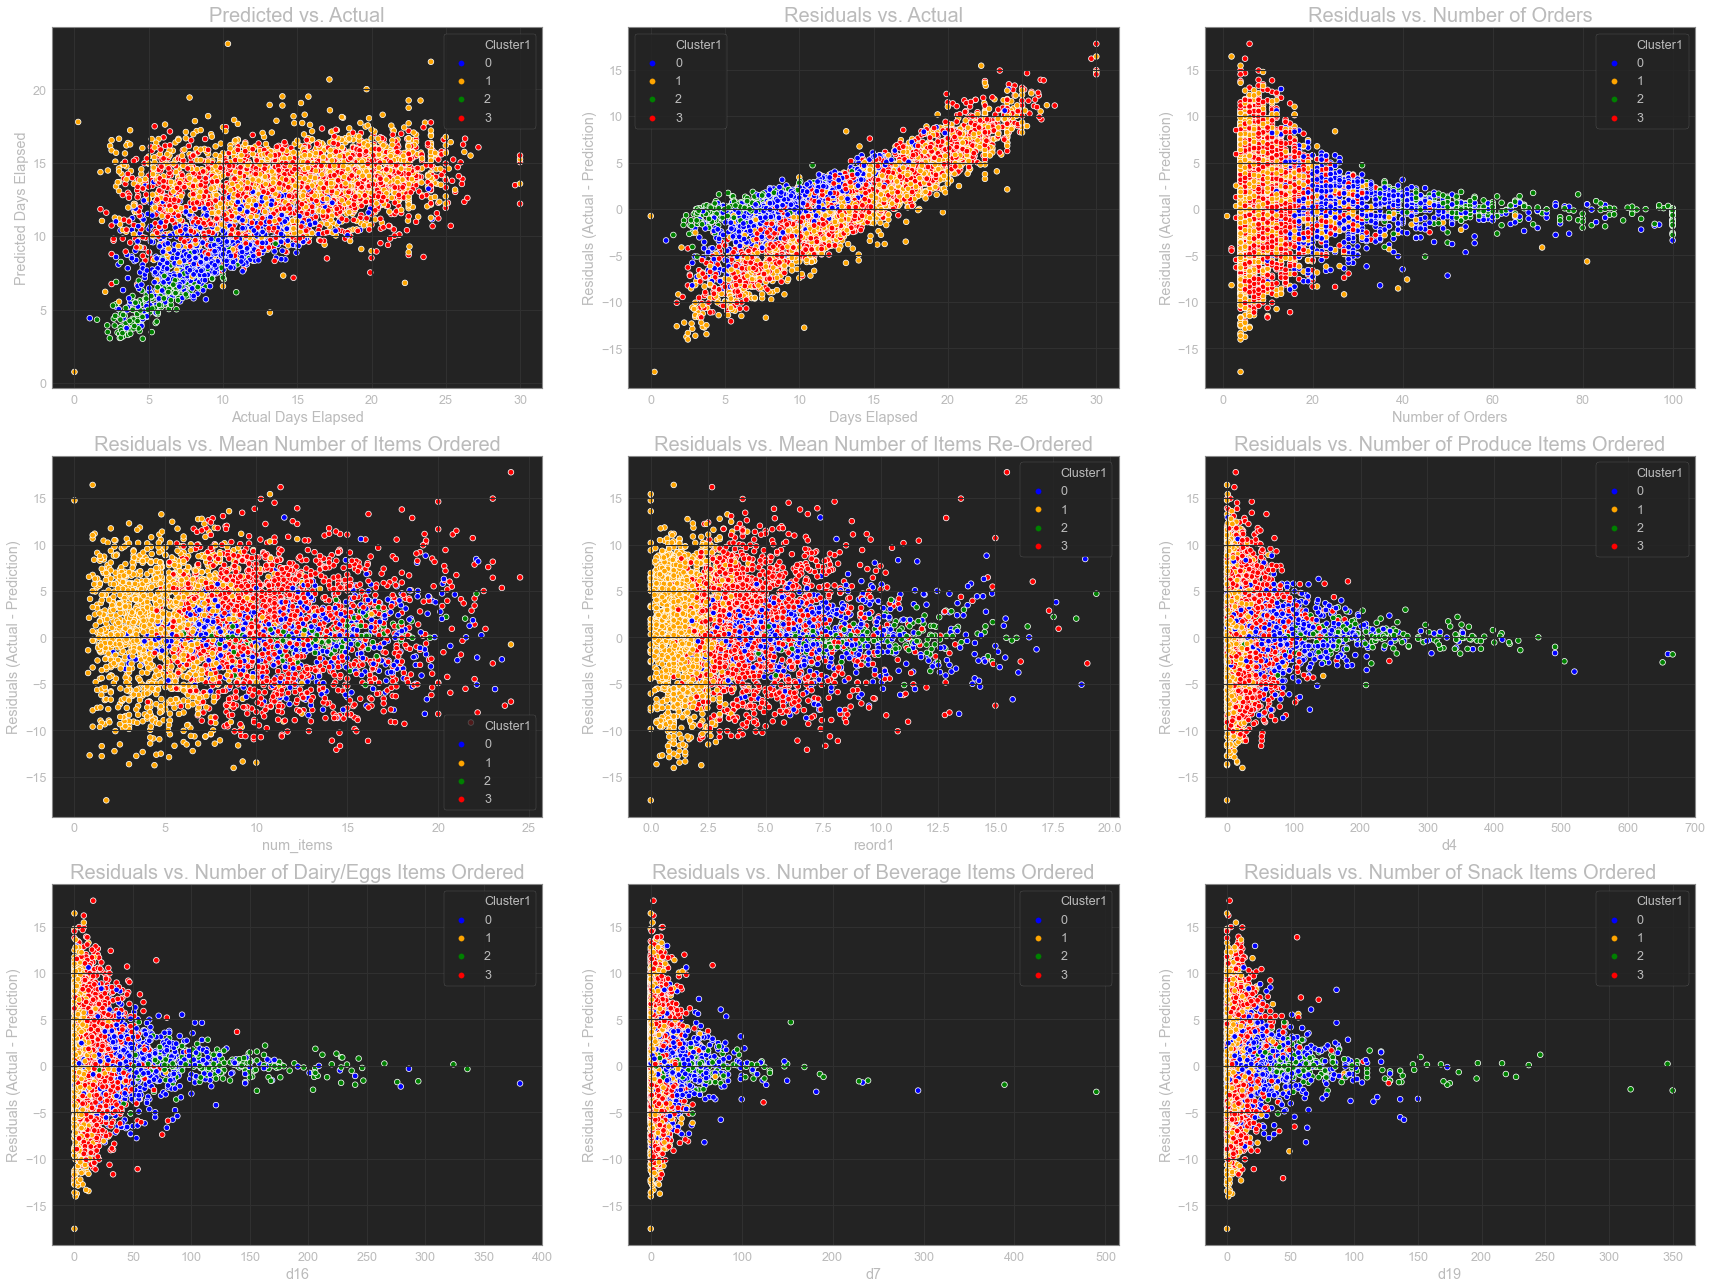

	--- RMSE=6.42 ---
--- Regression Error Analysis Completed in 32.09 seconds ---


In [23]:
# error analysis: residuals
regression_error_analysis(df_model, df_X_std, df_Y_std, x_scaler, y_scaler, rgr)

## gradient boosting regression

### default tuning

--- Gradient Boosting Regression: Default Parameters ---
--- run_regresor(): kwargs = {'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 1.0, 'loss': 'ls'} ---
	--- Selecting Regressor ---
	--- Executing cross-validation ---
	---        mean       std
0  0.654507  0.026989 ---


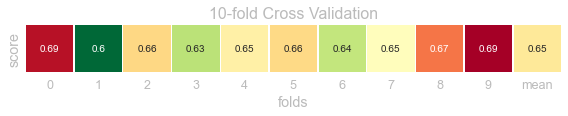

--- Completed in 83.5496 seconds



In [25]:
print('--- Gradient Boosting Regression: Default Parameters ---')
actual, predicted = run_regressor(X_std, Y_std, 'gbr',learning_rate=0.1, n_estimators=100, subsample=1.0, loss='ls')

### grid search

In [ ]:
print('--- Gradient Boosting Regression: Grid Search ---')

# start timer
t0 = time.time()

# define regressor
rgr = GradientBoostingRegressor()

# define parameters
param_grid = {
    'loss':['ls','lad','quantile'],
    'learning_rate':[0.1,0.9],
    'n_estimators':[100,300,500],
    'subsample':[0.1,1.0]
}

# run grid search
grid = GridSearchCV(rgr, param_grid, refit=True)

# fit to model
grid.fit(X_std,Y_std)

print('\t --- Best Parameters ---')
print('\t',grid.best_params_)

print(f'\t--- Gradient Boosting Regression grid search completed in {time.time()-t0:.2f} seconds')

### post-tuning

--- Gradient Boosting Regression: Tuned Parameters ---
--- run_regresor(): kwargs = {'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 1.0, 'loss': 'ls'} ---
	--- Selecting Regressor ---
	--- Executing cross-validation ---
	---        mean       std
0  0.654545  0.026971 ---


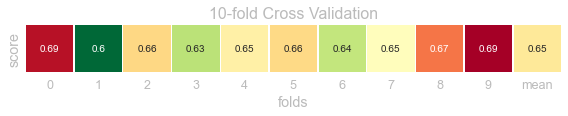

--- Completed in 83.6882 seconds



In [26]:
print('--- Gradient Boosting Regression: Tuned Parameters ---')
actual, predicted = run_regressor(X_std, Y_std, 'gbr',learning_rate=0.1, n_estimators=100, subsample=1.0, loss='ls')

In [27]:
rgr = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, subsample=1.0, loss='ls')

--- Feature Importance ---


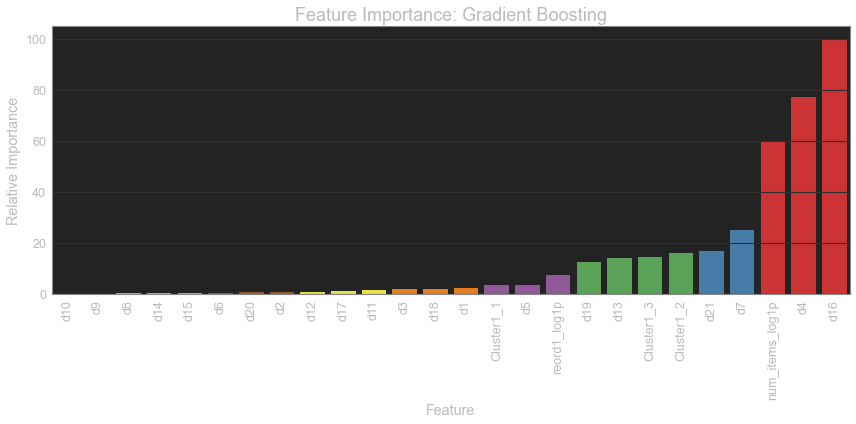

Feature Importance completed in 6.46 seconds.


In [28]:
# feature importance
rgr.fit(X_std,Y_std)
get_feature_importance(rgr, df_X_std, df_Y_std, 'Feature Importance: Gradient Boosting')

--- Regression Error Analysis ---


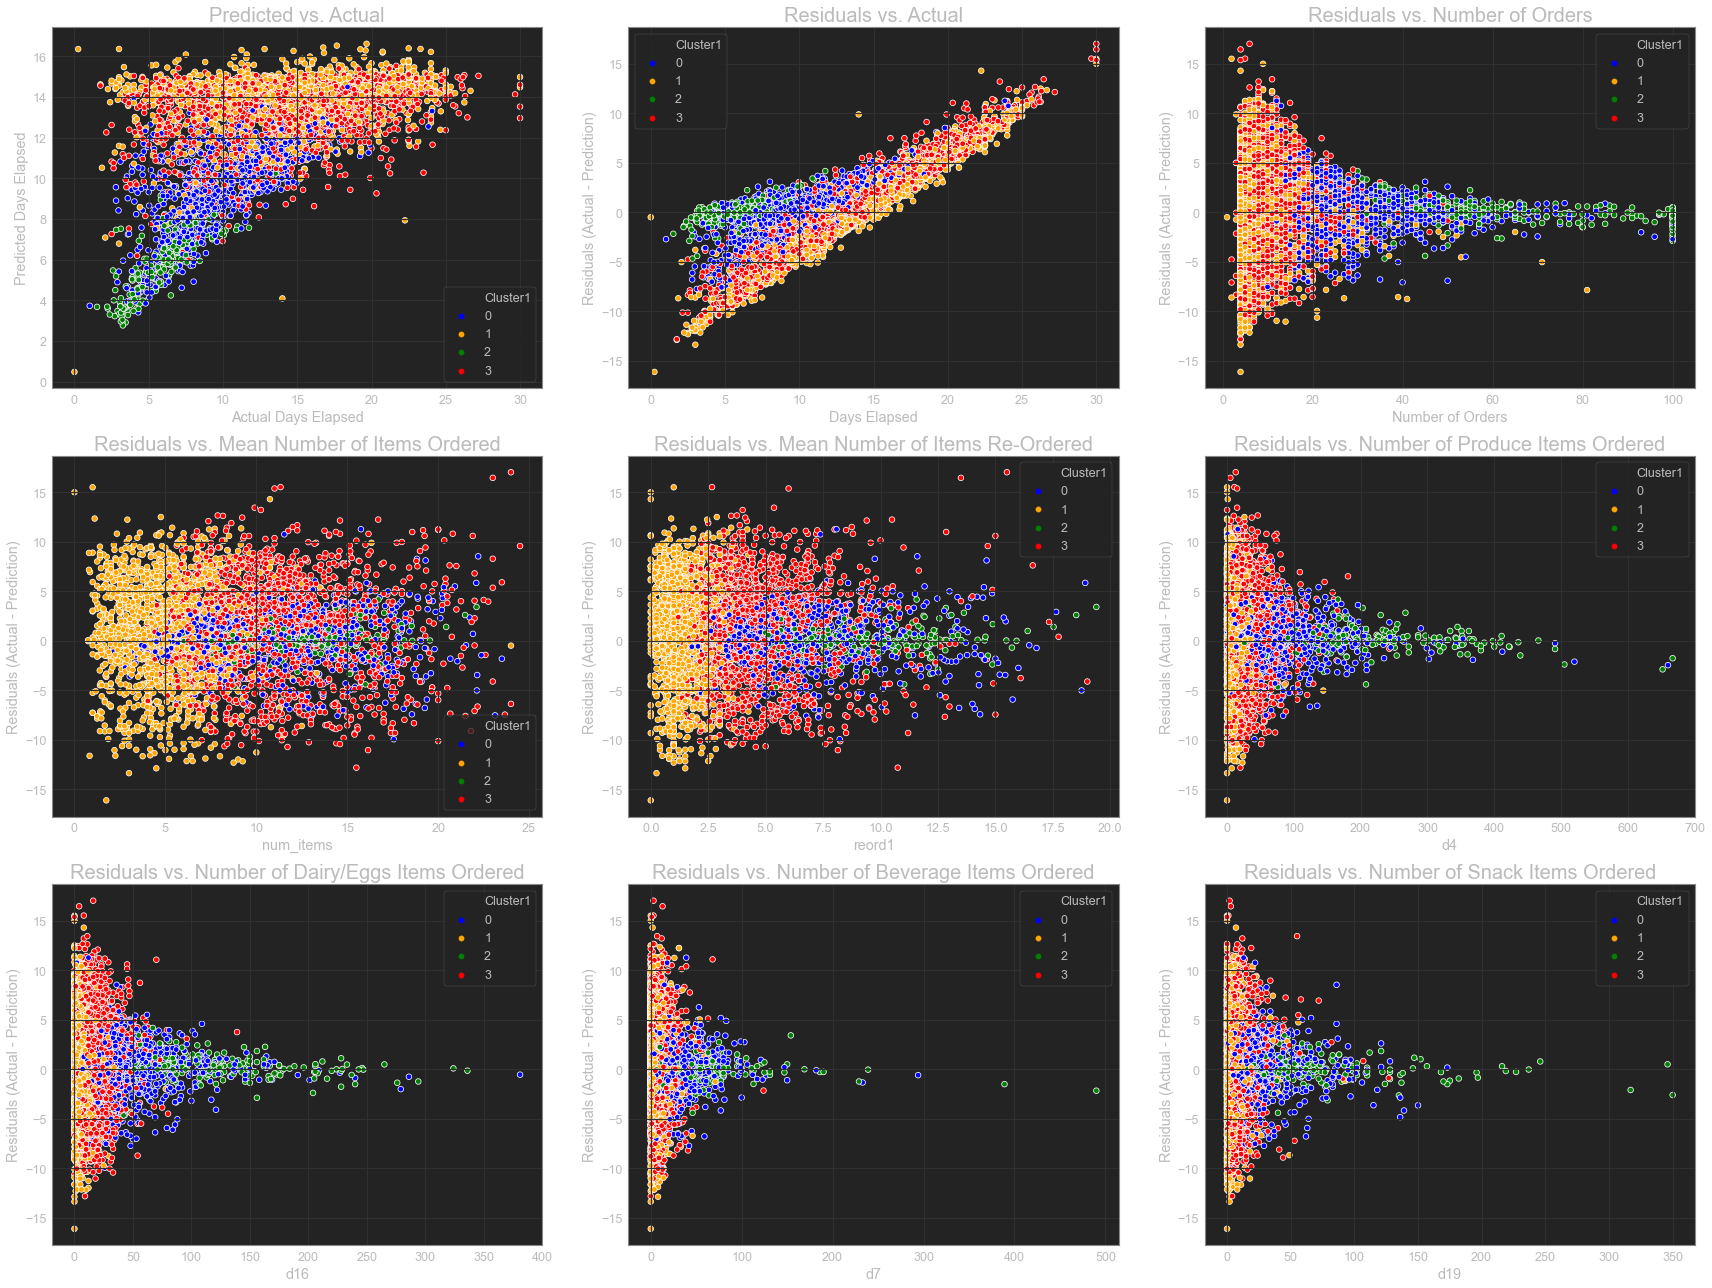

	--- RMSE=6.31 ---
--- Regression Error Analysis Completed in 10.82 seconds ---


In [29]:
# error analysis: residuals
regression_error_analysis(df_model, df_X_std, df_Y_std, x_scaler, y_scaler, rgr)

## support vector regression

### default tuning

--- Support Vector Regression: Default Parameters ---
--- run_regresor(): kwargs = {'C': 1.0, 'kernel': 'rbf', 'gamma': 'scale'} ---
	--- Selecting Regressor ---
	--- Executing cross-validation ---
	---        mean       std
0  0.695983  0.033753 ---


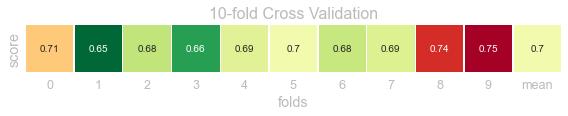

--- Completed in 325.0653 seconds



In [30]:
print('--- Support Vector Regression: Default Parameters ---')
actual, predicted = run_regressor(X_std,Y_std,'svr',C=1.0,kernel='rbf',gamma='scale')

### grid search

In [ ]:
print('--- Support Vector Regression: Grid Search')

# start timer
t0 = time.time()

# define regressor
rgr = SVR()

# define parameters
param_grid = {
    'C':[0.1, 1.0],
    'kernel':['linear','rbr','poly']
    'gamma':['scale','auto']
}

# run grid search
grid = GridSearchCV(rgr, param_grid, refit=True)

# fit to model
grid.fit(X_std,Y_std)

print('\t --- Best Parameters ---')
print('\t',grid.best_params_)

print(f'\t--- SVM Regression grid search completed in {time.time()-t0:.2f} seconds')

### post-tuning

In [ ]:
print('--- Support Vector Regression: Tuned Parameters ---')
actual, predicted = run_regressor(X_std,Y_std,'svr',C=1.0,kernel='rbf',gamma='scale')

In [31]:
rgr = SVR(C=1.0, kernel='rbf', gamma='scale')

--- Regression Error Analysis ---


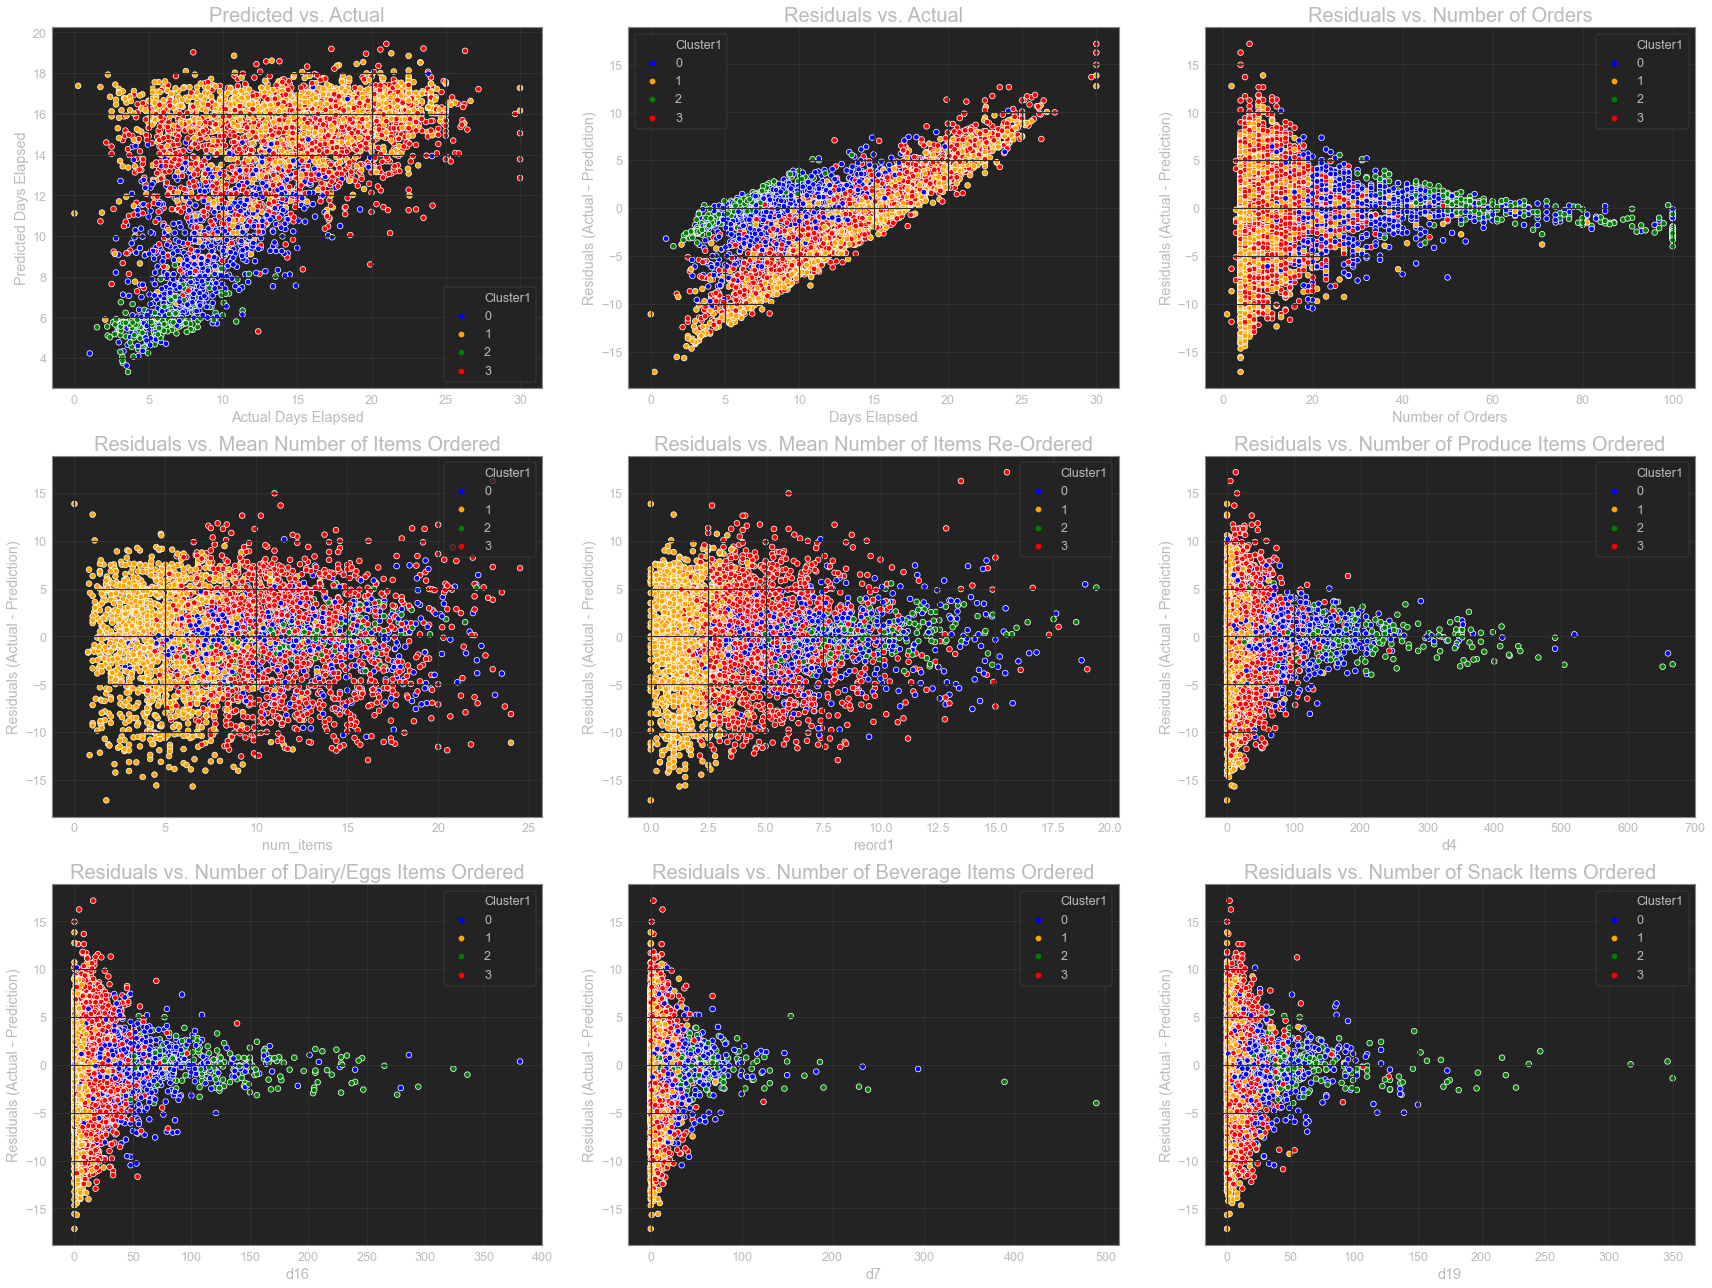

	--- RMSE=6.56 ---
--- Regression Error Analysis Completed in 30.57 seconds ---


In [32]:
regression_error_analysis(df_model, df_X_std, df_Y_std, x_scaler, y_scaler, rgr)

## knn regression

### default tuning

--- KNN Regression: Default Parameters ---
--- run_regresor(): kwargs = {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto'} ---
	--- Selecting Regressor ---
	--- Executing cross-validation ---
	---        mean       std
0  0.802414  0.031193 ---


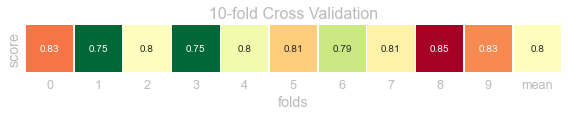

--- Completed in 49.2165 seconds



In [33]:
print('--- KNN Regression: Default Parameters ---')
actual, predicted = run_regressor(X_std, Y_std, 'knn',n_neighbors=5,weights='uniform', algorithm='auto')

### grid search

In [ ]:
print('--- KNN Regression: Grid Search ---')

# start timer
t0 = time.time()

# define regressor
rgr=KNeighborsRegressor()

# define parameters
param_grid = {
    'n_neighbors':[5,10,20,50,100],
    'weights':['uniform','distance'],
    'algorithm':['auto','ball_tree','kd_tree','brute']
}

# run grid search
grid = GridSearchCV(rgr, param_grid, refit=True)

# fit to model
grid.fit(X_std,Y_std)

print('\t --- Best Parameters ---')
print('\t',grid.best_params_)

print(f'\t--- KNN Regression grid search completed in {time.time()-t0:.2f} seconds')

### post-tuning

--- KNN Regression: Tuned Parameters ---
--- run_regresor(): kwargs = {'n_neighbors': 50, 'weights': 'distance', 'algorithm': 'ball_tree'} ---
	--- Selecting Regressor ---
	--- Executing cross-validation ---
	---        mean       std
0  0.712319  0.030637 ---


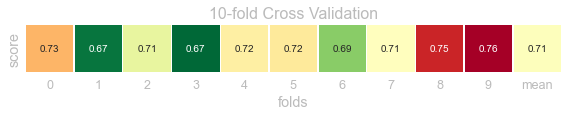

--- Completed in 50.4291 seconds



In [34]:
print('--- KNN Regression: Tuned Parameters ---')
actual, predicted = run_regressor(X_std, Y_std, 'knn',n_neighbors=50,weights='distance',algorithm='ball_tree')

In [35]:
rgr = KNeighborsRegressor(n_neighbors=50, weights='distance',algorithm='ball_tree')

--- Regression Error Analysis ---


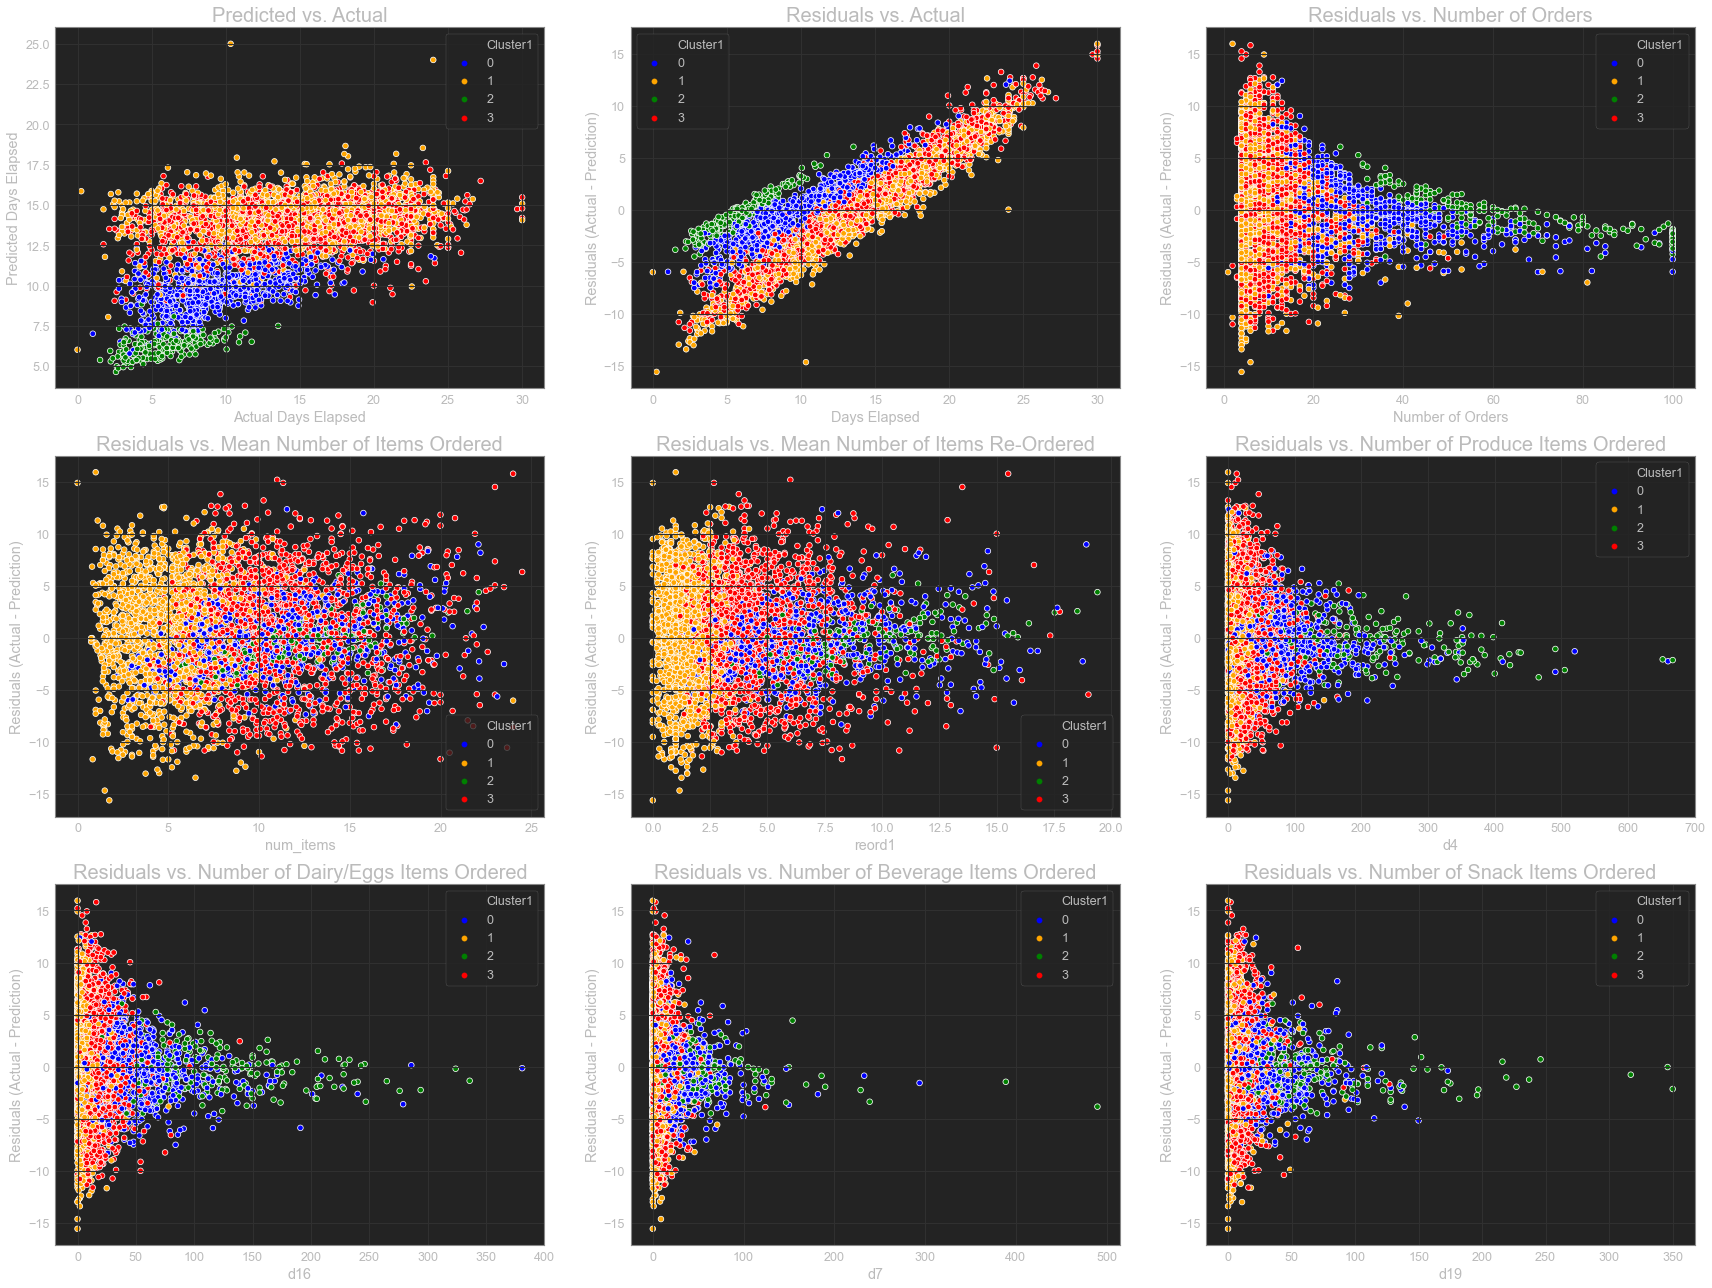

	--- RMSE=4.77 ---
--- Regression Error Analysis Completed in 13.91 seconds ---


In [36]:
regression_error_analysis(df_model, df_X_std, df_Y_std, x_scaler, y_scaler, rgr)

### knn on population

In [40]:
# copy original dataframe
df_model = df.copy()

# define model
df_model, df_X_std, df_Y_std, x_scaler, y_scaler, X_std, Y_std, X, Y = define_model(df_model, False)

if VERBOSE:
    print(df_model.shape)
    print(df_X_std.shape)
    print(df_Y_std.shape)
    print(X_std.shape)
    print(Y_std.shape)

if DEBUG:
    print(df_model.head())
    print(df_X_std.head())
    print(df_Y_std.head())

--- Defining Model ---
	--- Initial Features Selected ---
	--- One-Hot Encoding Completed ---
	--- Input Variable Standardization Completed ---
	--- Target Variable Defined and Standardized ---
(206059, 30)
(206059, 26)
(206059, 1)
(206059, 26)
(206059, 1)


In [41]:
rgr = KNeighborsRegressor(n_neighbors=50, weights='distance',algorithm='ball_tree')

--- Regression Error Analysis ---


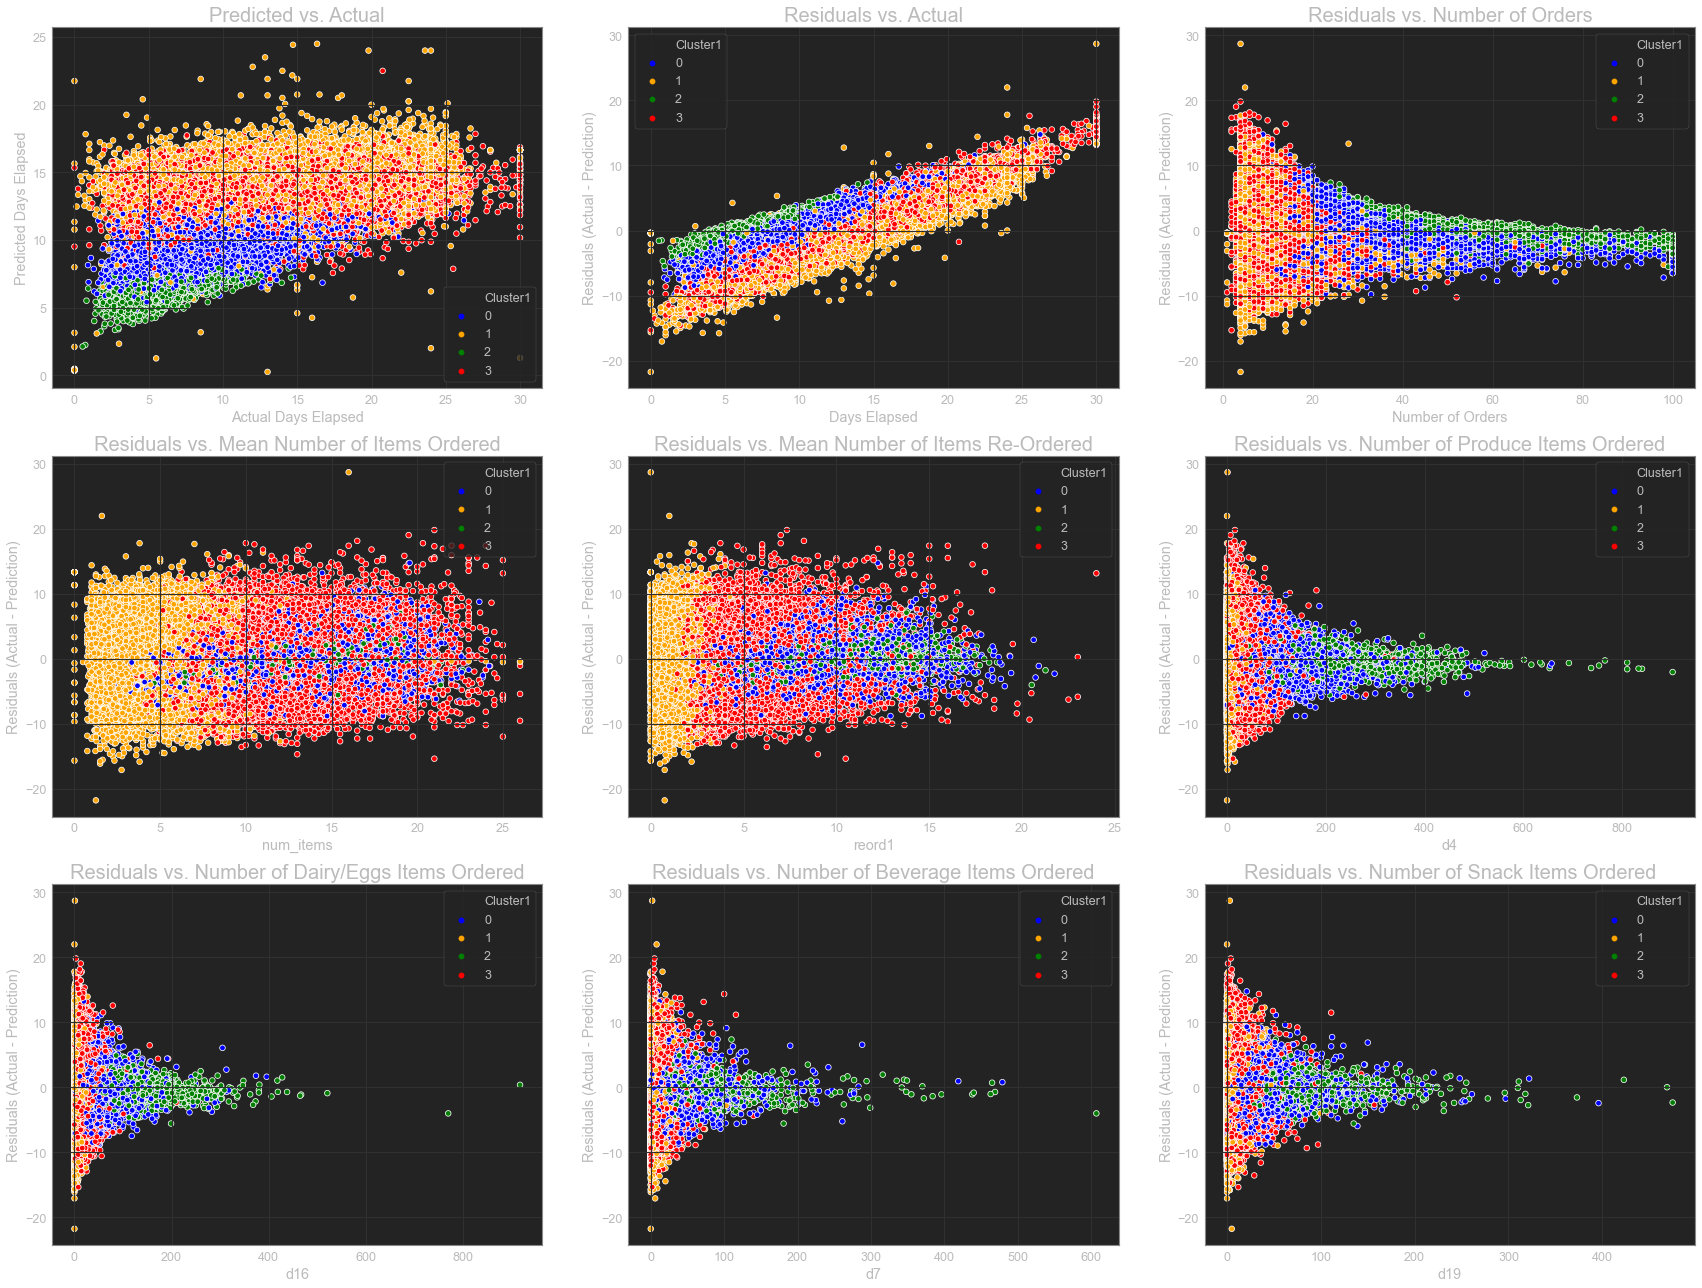

	--- RMSE=4.74 ---
--- Regression Error Analysis Completed in 1152.53 seconds ---


In [42]:
regression_error_analysis(df_model, df_X_std, df_Y_std, x_scaler, y_scaler, rgr)

### per cluster RMSE

#### cluster0

In [45]:
df_model = df.copy()
df_model = df_model[df_model.Cluster1==0]
df_model, df_X_std, df_Y_std, x_scaler, y_scaler, X_std, Y_std, X, Y = define_model(df_model, False)
rgr = KNeighborsRegressor(n_neighbors=50, weights='distance',algorithm='ball_tree')
regression_error_analysis(df_model, df_X_std, df_Y_std, x_scaler, y_scaler, rgr, False)

--- Defining Model ---
	--- Initial Features Selected ---
	--- One-Hot Encoding Completed ---
	--- Input Variable Standardization Completed ---
	--- Target Variable Defined and Standardized ---
--- Regression Error Analysis ---
	--- RMSE=2.77 ---
	--- MSE=7.68 ---
	--- MAE=0.04 ---
--- Regression Error Analysis Completed in 23.19 seconds ---


#### cluster1

In [46]:
df_model = df.copy()
df_model = df_model[df_model.Cluster1==1]
df_model, df_X_std, df_Y_std, x_scaler, y_scaler, X_std, Y_std, X, Y = define_model(df_model, False)
rgr = KNeighborsRegressor(n_neighbors=50, weights='distance',algorithm='ball_tree')
regression_error_analysis(df_model, df_X_std, df_Y_std, x_scaler, y_scaler, rgr, False)

--- Defining Model ---
	--- Initial Features Selected ---
	--- One-Hot Encoding Completed ---
	--- Input Variable Standardization Completed ---
	--- Target Variable Defined and Standardized ---
--- Regression Error Analysis ---
	--- RMSE=5.34 ---
	--- MSE=28.50 ---
	--- MAE=-0.70 ---
--- Regression Error Analysis Completed in 102.93 seconds ---


#### cluster2

In [47]:
df_model = df.copy()
df_model = df_model[df_model.Cluster1==2]
df_model, df_X_std, df_Y_std, x_scaler, y_scaler, X_std, Y_std, X, Y = define_model(df_model, False)
rgr = KNeighborsRegressor(n_neighbors=50, weights='distance',algorithm='ball_tree')
regression_error_analysis(df_model, df_X_std, df_Y_std, x_scaler, y_scaler, rgr, False)

--- Defining Model ---
	--- Initial Features Selected ---
	--- One-Hot Encoding Completed ---
	--- Input Variable Standardization Completed ---
	--- Target Variable Defined and Standardized ---
--- Regression Error Analysis ---
	--- RMSE=1.25 ---
	--- MSE=1.57 ---
	--- MAE=0.24 ---
--- Regression Error Analysis Completed in 1.25 seconds ---


#### cluster3

In [48]:
df_model = df.copy()
df_model = df_model[df_model.Cluster1==3]
df_model, df_X_std, df_Y_std, x_scaler, y_scaler, X_std, Y_std, X, Y = define_model(df_model, False)
rgr = KNeighborsRegressor(n_neighbors=50, weights='distance',algorithm='ball_tree')
regression_error_analysis(df_model, df_X_std, df_Y_std, x_scaler, y_scaler, rgr, False)

--- Defining Model ---
	--- Initial Features Selected ---
	--- One-Hot Encoding Completed ---
	--- Input Variable Standardization Completed ---
	--- Target Variable Defined and Standardized ---
--- Regression Error Analysis ---
	--- RMSE=5.02 ---
	--- MSE=25.21 ---
	--- MAE=-0.66 ---
--- Regression Error Analysis Completed in 143.89 seconds ---
